In [1]:
# https://github.com/anminhhung/oput
!pip install git+https://github.com/anminhhung/oput

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/anminhhung/oput to /tmp/pip-req-build-ac8sjysn
  Running command git clone --filter=blob:none --quiet https://github.com/anminhhung/oput /tmp/pip-req-build-ac8sjysn
  Resolved https://github.com/anminhhung/oput to commit 440047ff8be0bf4bd0c3d501b2081307cfc56c4c
  Preparing metadata (setup.py) ... done
  Created wheel for oput: filename=oput-0.1.1-py3-none-any.whl size=71292 sha256=b454e6df00598cf2e59bf76397b7fcb753dc779d0b631cb95089d0279a159263
  Stored in directory: /tmp/pip-ephem-wheel-cache-b56uegqo/wheels/f0/a1/fc/36ba21f83a1426ae8ed7cb4ee1715d8cda68bfce2ed57bb608
Successfully built oput


In [2]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

Cloning into 'small_dog_cat_dataset'...
remote: Enumerating objects: 2608, done.
remote: Total 2608 (delta 0), reused 0 (delta 0), pack-reused 2608
Receiving objects: 100% (2608/2608), 55.84 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os
import oput

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataloader

In [5]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    
    self.transform = transform
  
  def __len__(self):
    return len(self.list_images_path)
  
  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float')
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)
    
    return sample # image, label

In [6]:
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()

    return (image, label)

In [7]:
transformed_train_data = DogCatDataset('small_dog_cat_dataset/train', transform=transforms.Compose([convertToTensor()]))
transformed_test_data = DogCatDataset('small_dog_cat_dataset/test', transform=transforms.Compose([convertToTensor()]))

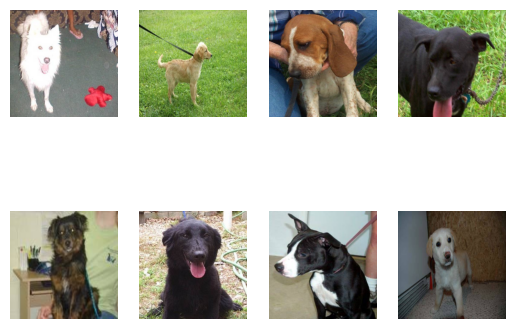

In [8]:
col = 4
row = 2

fig = plt.figure()
for index in range(1, col*row + 1):
  plt.subplot(row, col, index)
  plt.axis('off')
  plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[index]), cv2.COLOR_BGR2RGB), (224, 224)))

In [9]:
train_data_loader = DataLoader(transformed_train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

# Helper

## Normal 

In [10]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')
  

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

## MOMO optim 

In [11]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

def loss_fn(criterion, running_loss, outputs, labels):
  loss = criterion(outputs, labels)
  running_loss += loss.item()
  loss.backward()

  return loss

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        optimizer.zero_grad()

        closure = lambda: loss_fn(criterion, running_loss, outputs, labels) # define a closure that return loss

        optimizer.step(closure)

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

# Model

In [12]:
class VGG16(nn.Module):
    def __init__(self, n_classes=2):
        super(VGG16, self).__init__()

        self.feature_extractor = nn.Sequential(
            self.create_conv_block([3, 64], [64, 64], [3, 3], [1, 1], 2, 2),
            self.create_conv_block([64, 128], [128, 128], [3, 3], [1, 1], 2, 2),
            self.create_conv_block([128, 256, 256], [256, 256, 256], [3, 3, 3], [1, 1, 1], 2, 2),
            self.create_conv_block([256, 512, 512], [512, 512, 512], [3, 3, 3], [1, 1, 1], 2, 2),
            self.create_conv_block([512, 512, 512], [512, 512, 512], [3, 3, 3], [1, 1, 1], 2, 2),
        )

        self.flatten = nn.Flatten() 

        self.FC_layer = nn.Sequential(
            self.create_fc_layer(7*7*512, 1028),
            self.create_fc_layer(1028, 512),
        )

        self.classifier = nn.Linear(in_features=512, out_features=n_classes)
    
    def forward(self, x):
        output = self.feature_extractor(x)
        output = self.flatten(output)
        output = self.FC_layer(output)
        output = self.classifier(output)

        return output

    
    def create_conv_layer(self, chann_in, chann_out, kernel_size, padding_size):
        layer = nn.Sequential(
            nn.Conv2d(chann_in, chann_out, kernel_size=kernel_size, padding=padding_size),
            nn.BatchNorm2d(chann_out),
            nn.ReLU()
        )

        return layer 
    
    def create_conv_block(self, list_chann_in, list_chann_out, list_kernel_size, list_padding_size, pooling_kernel, pooling_Stride):
        layers = [self.create_conv_layer(list_chann_in[i], list_chann_out[i], list_kernel_size[i], list_padding_size[i])
                    for i in range(len(list_chann_in))]
        
        layers += [nn.MaxPool2d(kernel_size=pooling_kernel, stride=pooling_Stride)]

        return nn.Sequential(*layers)
    
    def create_fc_layer(self, chann_in, chann_out):
        layer = nn.Sequential(
            nn.Linear(chann_in, chann_out),
            nn.ReLU()
        )

        return layer 

# Custom optimizer

In [16]:
model = VGG16(2).to(device)

optimizer = oput.SophiaG(
    model.parameters(), 
    lr=2e-4, 
    betas=(0.965, 0.99), 
    rho = 0.01, 
    weight_decay=1e-1
)

loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 0.0, Valid_loss: 4.451808449469115, Train_accuracy: 50.24999999999999, Valid_accuracy: 49.833333333333336
Epochs: 1, Train_loss: 0.0, Valid_loss: 0.7249898283105147, Train_accuracy: 54.25, Valid_accuracy: 53.666666666666664
Epochs: 2, Train_loss: 0.0, Valid_loss: 0.7753825187683105, Train_accuracy: 53.849999999999994, Valid_accuracy: 53.333333333333336


<ipython-input-11-a11d8d97d2c9>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


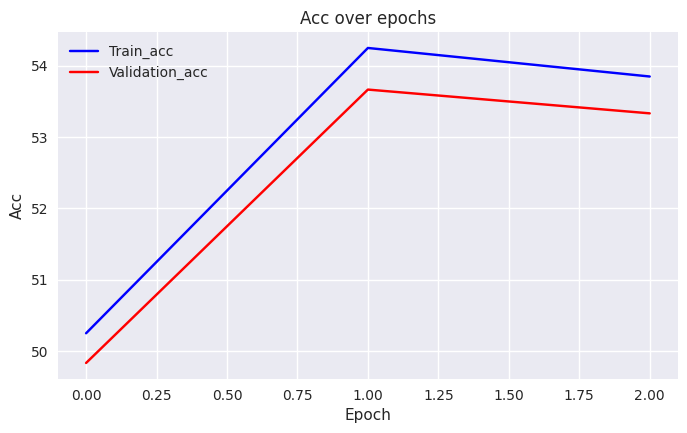

In [17]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 3, device)

In [ ]:
# tesst backbone => MOdel CNN, VIT use classifcation => oBject detection (goi la backbone)
# test optimizer 
# test trainsfer learning
# test init 